[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanfobel/gridwatch-history/setup-binder-link)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

sys.path.insert(0, ".")

# Plotting preferences
from matplotlib import rcParams

%matplotlib inline

rcParams.update({"figure.figsize": (12, 6)})
bin_width = 0.9
alpha = 0.5
transparent = False
bbox_inches = "tight"
facecolor = "white"

In [2]:
import datetime as dt
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arrow

# Download CARMA database here: https://www.cgdev.org/sites/default/files/CARMAv30_PowerUser.zip


def extract_datetime_from_string_list(str_list: List[str]) -> pd.Series:
    # Example of the string index: 'Thu Oct 14, 8 AM - 9 AM'
    df = pd.Series(str_list).str.extract(
        r'(?P<dow>[a-zA-Z]{3}) '
        r'(?P<month>[a-zA-Z]{3}) '
        r'(?P<day>\d+), '
        r'(?P<start_hour>\d+) '
        r'(?P<start_AMPM>[A-Z]{2}) - '
        r'(?P<end_hour>\d+) '
        r'(?P<end_AMPM>[A-Z]{2})'
    )
    # convert types
    df = df.dropna()
    df["start_hour"] = df["start_hour"].astype(int)
    df["end_hour"] = df["end_hour"].astype(int)

    # Convert 3-letter month into number
    months = list(set(df["month"].values))
    month_letters_to_number = dict(zip(months, [dt.datetime.strptime(mon, '%b').month for mon in months]))
    df["month"] = df["month"].map(month_letters_to_number)

    df = df.drop(columns=["dow"]).dropna().copy()

    # Find the indices where the months and years "rollover"
    month_rollover_index = df[:-1][
        df.loc[df.index[1:], "month"].values !=
        df.loc[df.index[:-1], "month"].values
    ].index

    year_rollover_index = df.loc[month_rollover_index[:-1]][
        df.loc[month_rollover_index[1:], "month"].values <
        df.loc[month_rollover_index[:-1], "month"].values
    ].index

    # Assume the most recent date is from the current year
    end_year = dt.datetime.now().year
    df["year"] = end_year

    for index in reversed(year_rollover_index):
        df.loc[:index, "year"] = df.loc[:index, "year"] - 1

    # Convert to 24hr time
    start_hour_lt_12_and_PM_index = df[(df["start_hour"] < 12) & (df["start_AMPM"] == "PM")].index
    df.loc[start_hour_lt_12_and_PM_index, "start_hour"] = df.loc[start_hour_lt_12_and_PM_index, "start_hour"] + 12
    start_hour_12_and_AM_index = df[(df["start_hour"] == 12) & (df["start_AMPM"] == "AM")].index
    df.loc[start_hour_12_and_AM_index, "start_hour"] = 0

    # Drop extra columns
    df = df.drop(columns={"end_AMPM", "start_AMPM", "end_hour"})
    df = df.rename(columns={"start_hour": "hour"})
    df["dt"] = pd.to_datetime(df)

    hr_23_index = df[df["hour"] == 23].index
    df.loc[hr_23_index, "dt"] = df.loc[hr_23_index, "dt"] - pd.Timedelta(1, "d")

    return df["dt"]

In [3]:
def cleanup(df: pd.DataFrame):
    df = df.copy()
    dt_index = extract_datetime_from_string_list(df.index)
    df = df.reset_index().loc[dt_index.index]
    df.index = dt_index.values
    df = df.drop(columns="index")

    percentage_cols = [col for col in df.columns if col.endswith('Percentage')]
    for col in df[percentage_cols]:
        df[col] = df[col].str.replace("%", "").astype(float)
    df = df.rename(columns={col: f"{col.replace('Percentage', '')} (%)" for col in percentage_cols})
    
    output_cols = [col for col in df.columns if col.endswith('Output')]
    mw_cols = output_cols + ["imports", "exports", "netImportExports", "POWER GENERATED"]
    for col in df[mw_cols]:
        df[col] = df[col].str.replace(" MW", "")
        df[col] = df[col].str.replace(",", "").astype(float)
    df = df.rename(columns={col: f"{col.replace('Output', '')} (MW)" for col in output_cols})

    df['TOTAL EMISSIONS'] = df['TOTAL EMISSIONS'].str.replace(" tonnes", "")
    df['TOTAL EMISSIONS'] = df['TOTAL EMISSIONS'].str.replace(",", "").astype(float)
    df['ONTARIO DEMAND'] = df['ONTARIO DEMAND'].str.replace(" MW", "")
    df['ONTARIO DEMAND'] = df['ONTARIO DEMAND'].str.replace(",", "").astype(float)
    df['CO2e INTENSITY'] = df['CO2e INTENSITY'].str.replace(" g/kWh", "").astype(float)

    df = df.rename(columns={
        "imports": "Imports (MW)",
        "exports": "Exports (MW)",
        "netImportExports": "Net Import/Exports (MW)",
        "POWER GENERATED": "Power Generated (MW)",
        "ONTARIO DEMAND": "Ontario Demand (MW)",
        "TOTAL EMISSIONS": "Total Emissions (tonnes)",
        "CO2e INTENSITY": "CO2e Intensity (g/kWh)",
    })

    return df

df_capability = pd.read_csv("../data/capability.csv", thousands=',')
df_plants = pd.read_csv("../data/plants.csv")
df_output = pd.read_csv("../data/output.csv", index_col=0, thousands=',')
df_summary = cleanup(pd.read_csv("../data/summary.csv", index_col=0, thousands=','))

df_summary.head()

,Imports (MW),Exports (MW),Net Import/Exports (MW),Power Generated (MW),Ontario Demand (MW),Total Emissions (tonnes),CO2e Intensity (g/kWh),nuclear (%),hydro (%),gas (%),wind (%),biofuel (%),solar (%),nuclear (MW),hydro (MW),gas (MW),wind (MW),biofuel (MW),solar (MW)
2021-10-14 08:00:00,1216.0,1565.0,349.0,15435.0,15086.0,769.0,50.0,54.7,23.3,14.8,6.7,0.2,0.3,8445.0,3594.0,2291.0,1033.0,31.0,41.0
2021-10-14 09:00:00,1239.0,1513.0,274.0,15536.0,15262.0,759.0,49.0,54.4,24.6,14.9,5.3,0.2,0.6,8444.0,3820.0,2308.0,826.0,38.0,100.0
2021-10-14 10:00:00,1105.0,1523.0,418.0,15824.0,15406.0,970.0,61.0,53.4,23.0,17.8,4.2,0.3,1.3,8445.0,3647.0,2820.0,665.0,47.0,200.0
2021-10-14 11:00:00,920.0,1711.0,791.0,16361.0,15570.0,1024.0,63.0,51.6,23.8,19.2,3.7,0.3,1.3,8447.0,3900.0,3144.0,605.0,47.0,218.0
2021-10-14 12:00:00,919.0,1458.0,539.0,16222.0,15683.0,1042.0,64.0,52.1,23.5,19.3,3.4,0.3,1.4,8457.0,3817.0,3128.0,551.0,43.0,226.0


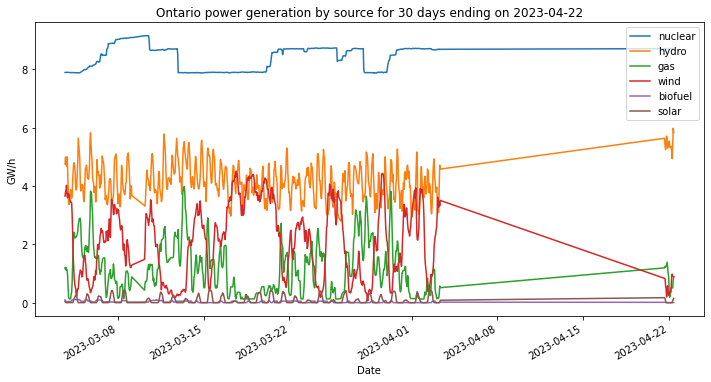

In [5]:
output_types = [col.replace(' (%)', '') for col in df_summary.columns if col.endswith(' (%)')]
output_cols = [f"{col} (MW)" for col in output_types]
(df_summary[output_cols].iloc[-30*24:] / 1e3).plot()
plt.ylabel('GW/h')
plt.xlabel('Date')
plt.title(f'Ontario power generation by source for 30 days ending on {df_summary.index[-1].date().isoformat()}')
plt.legend([col.replace(' (MW)', '') for col in output_cols])
plt.savefig(
    os.path.join("images", "ontario_power_generation_by_source_30_day.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

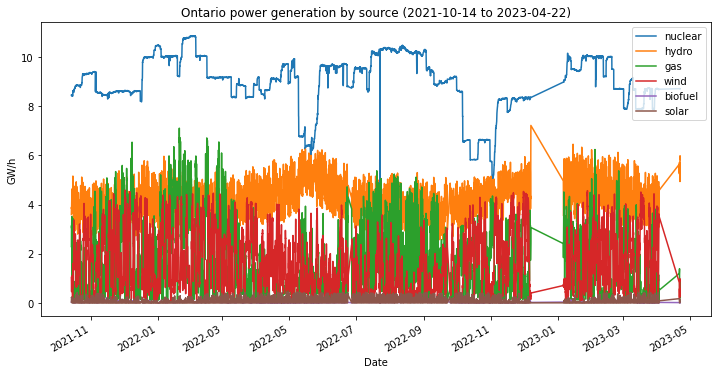

In [6]:
(df_summary[output_cols] / 1e3).plot()
plt.ylabel('GW/h')
plt.xlabel('Date')
plt.title(f'Ontario power generation by source ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.legend([col.replace(' (MW)', '') for col in output_cols])
plt.savefig(
    os.path.join("images", "ontario_power_generation_by_source.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

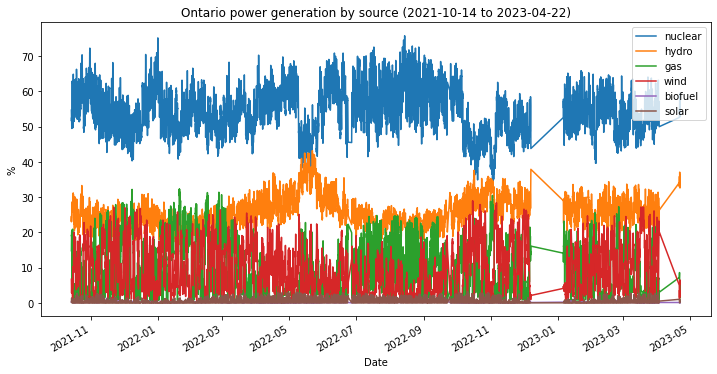

In [7]:
percentage_cols = [f"{col} (%)" for col in output_types]

df_summary[percentage_cols].plot()
plt.ylabel('%')
plt.xlabel('Date')
plt.title(f'Ontario power generation by source ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.legend([col.replace(' (%)', '') for col in percentage_cols])
plt.savefig(
    os.path.join("images", "ontario_power_generation_by_source_percentage.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

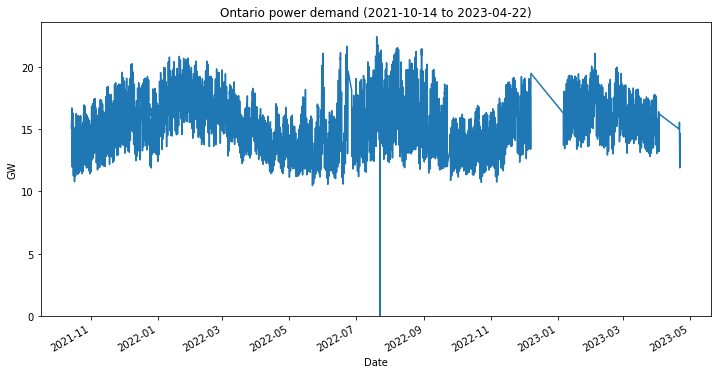

In [8]:
(df_summary['Ontario Demand (MW)'] / 1e3).plot()
plt.ylabel('GW')
plt.xlabel('Date')
plt.ylim([0, None])
plt.title(f'Ontario power demand ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.savefig(
    os.path.join("images", "ontario_power_demand.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

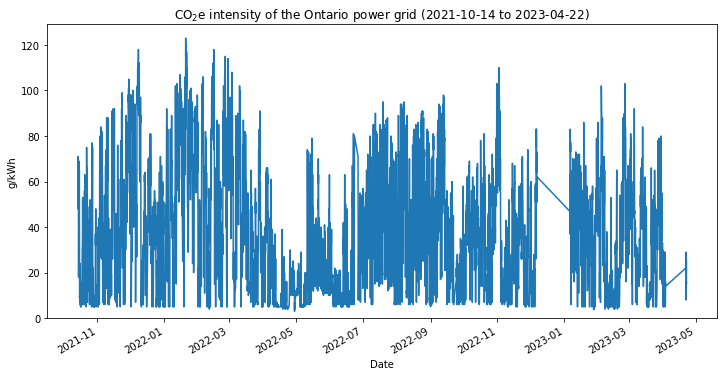

In [9]:
df_summary['CO2e Intensity (g/kWh)'].plot()
plt.ylabel('g/kWh')
plt.xlabel('Date')
plt.ylim([0, None])
plt.title(f'CO$_2$e intensity of the Ontario power grid ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.savefig(
    os.path.join("images", "ontario_co2_intensity.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

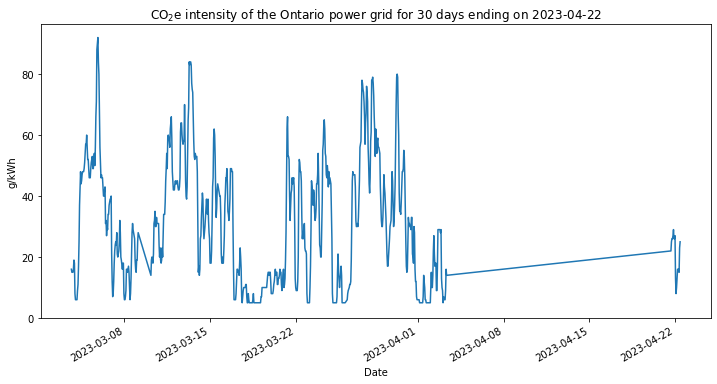

In [10]:
df_summary['CO2e Intensity (g/kWh)'].iloc[-24*30:].plot()
plt.ylabel('g/kWh')
plt.xlabel('Date')
plt.ylim([0, None])
plt.title(f'CO$_2$e intensity of the Ontario power grid for 30 days ending on {df_summary.index[-1].date().isoformat()}')
plt.savefig(
    os.path.join("images", "ontario_co2_intensity_30_day.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

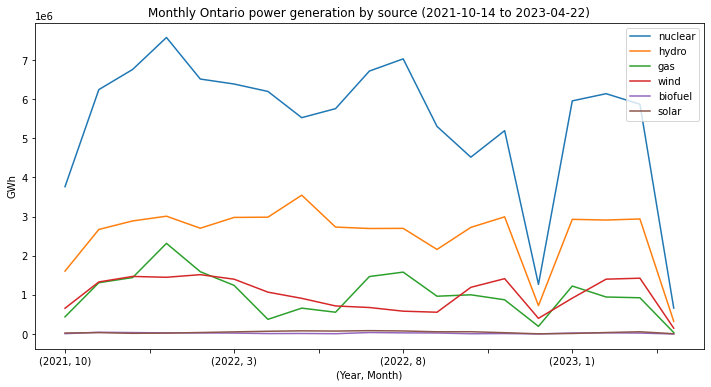

In [11]:
df_summary["month"] = df_summary.index.month
df_summary["year"] = df_summary.index.year
df_summary.groupby(["year", "month"]).sum()[output_cols].plot()
plt.ylabel('GWh')
plt.xlabel('(Year, Month)')
plt.title(f'Monthly Ontario power generation by source ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.legend([col.replace(' (MW)', '') for col in output_cols])
plt.savefig(
    os.path.join("images", "Monthly ontario power generation_by_source.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)